# 14日リターン戦略バックテスト
## Large Q5 Long + Small Q5 Short Strategy

**戦略概要:**
- **Large Q5 Long**: 大型銘柄の14日リターン上位20%をロング
- **Small Q5 Short**: 小型銘柄の14日リターン上位20%をショート
- **期間**: 2023/1/1 ~ 現在
- **ポジション**: Long 50% + Short 50% = 100%投資
- **リバランス**: 日次


In [1]:
# 1. ライブラリのインポートと設定

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
import warnings
from datetime import datetime
from tqdm import tqdm
import time

# 設定
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print("ライブラリインポート完了")


C:\Users\kifa3\AppData\Local\Temp\ipykernel_3632\3820735003.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ライブラリインポート完了


In [2]:
# 2. データ取得設定

# Binance設定
exchange = ccxt.binance({
    'apiKey': '',
    'secret': '',
    'sandbox': False,
    'options': {'defaultType': 'future'}
})

# バックテスト期間
start_date = datetime(2023, 1, 1)
end_date = datetime.now()

print(f"バックテスト期間: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
print(f"期間: {(end_date - start_date).days} 日間")


バックテスト期間: 2023-01-01 ~ 2026-01-15
期間: 1110 日間


In [3]:
# 3. データ収集関数（簡略版）

def get_futures_symbols_simple():
    """Binance先物銘柄一覧を取得"""
    markets = exchange.load_markets()
    symbols = [symbol for symbol, market in markets.items() 
              if market['type'] == 'swap' and symbol.endswith('USDT')]
    return symbols

def get_historical_data_simple(symbol, start_date, end_date):
    """日足データ取得"""
    try:
        since = int(start_date.timestamp() * 1000)
        ohlcv = []
        current_since = since
        
        while current_since < int(end_date.timestamp() * 1000):
            data = exchange.fetch_ohlcv(symbol, '1d', current_since, 1000)
            if not data:
                break
            ohlcv.extend(data)
            current_since = data[-1][0] + 86400000
            time.sleep(0.1)
            
        if ohlcv:
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['symbol'] = symbol
            df['returns'] = df['close'].pct_change()
            df['volume_usd'] = df['close'] * df['volume']
            return df
    except Exception as e:
        print(f"エラー {symbol}: {str(e)}")
        return None

print("データ取得関数準備完了")


データ取得関数準備完了


In [11]:
# 4. データ収集実行（修正版：日次フィルタ用に全銘柄データ取得）

def collect_data_for_backtest():
    """バックテスト用データ収集（全銘柄）"""
    symbols = get_futures_symbols_simple()
    
    all_data = []
    valid_symbols = []
    
    print("データ収集開始（全銘柄取得）...")
    print("※ 出来高フィルタは日次で動的に適用します")
    
    for symbol in tqdm(symbols):
        df = get_historical_data_simple(symbol, start_date, end_date)
        
        if df is not None and len(df) > 100:  # 100日以上のデータのみ
            all_data.append(df)
            valid_symbols.append(symbol)
    
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=False)
        print(f"\n取得銘柄数: {len(valid_symbols)}")
        print(f"総データポイント: {len(combined_data):,}")
        print("※ 各取引日に14日平均出来高1M以上の銘柄を動的に選択します")
        return combined_data, valid_symbols
    else:
        return None, []

# データ収集実行
market_data, valid_symbols = collect_data_for_backtest()


データ収集開始（全銘柄取得）...
※ 出来高フィルタは日次で動的に適用します


 13%|█▎        | 80/615 [00:40<03:33,  2.50it/s]

エラー BTCST/USDT:USDT: binance {"code":-1122,"msg":"Invalid symbol status."}


 97%|█████████▋| 595/615 [03:12<00:04,  4.56it/s]

エラー GAIB/USDT:USDT: binance {"code":-1122,"msg":"Invalid symbol status."}


100%|██████████| 615/615 [03:17<00:00,  3.11it/s]


取得銘柄数: 559
総データポイント: 350,516
※ 各取引日に14日平均出来高1M以上の銘柄を動的に選択します


In [13]:
# 5. 戦略ロジック実装（修正版：サイズ分類を削除し基本計算のみ）

def prepare_strategy_data(market_data, valid_symbols):
    """戦略用データ準備（基本計算のみ、フィルタは日次で実施）"""
    
    processed_data = []
    
    for symbol in valid_symbols:
        symbol_data = market_data[market_data['symbol'] == symbol].copy()
        
        if len(symbol_data) < 35:  # 14日 + 余裕
            continue
        # 14日平均出来高計算（日次フィルタ用、前日までの14日平均）
        symbol_data['volume_usd_14d_avg'] = symbol_data['volume_usd'].rolling(window=14).mean().shift(1)
        
        # 14日リターン計算
        symbol_data['return_14d'] = symbol_data['returns'].rolling(window=14).sum()
        
        # データリーク防止：シグナルを1日シフト
        symbol_data['signal'] = symbol_data['return_14d'].shift(1)
        
        # 翌日リターン（予測対象）
        symbol_data['next_day_return'] = symbol_data['returns'].shift(-1)
        
        # 過去100日データ存在チェック用
        symbol_data['days_available'] = symbol_data.index.to_series().diff().dt.days.fillna(1).cumsum()
        
        # 欠損値除去
        symbol_data = symbol_data.dropna(subset=['signal', 'next_day_return', 'volume_usd_14d_avg'])
        
        if len(symbol_data) > 20:
            processed_data.append(symbol_data)
    
    # 全データ結合
    final_data = pd.concat(processed_data, ignore_index=False)
    
    print(f"戦略データ準備完了: {len(final_data):,} レコード")
    print(f"対象銘柄数: {len(processed_data)}")
    print("※ 日次で14日平均出来高1M以上の銘柄を動的にフィルタします")
    
    return final_data

# データ準備実行
if market_data is not None:
    strategy_data = prepare_strategy_data(market_data, valid_symbols)
else:
    print("市場データが取得できていません。")


戦略データ準備完了: 341,572 レコード
対象銘柄数: 559
※ 日次で14日平均出来高1M以上の銘柄を動的にフィルタします


In [14]:
# 6. バックテストエンジン（修正版：日次で銘柄フィルタとサイズ分類を実施）

def run_backtest(strategy_data):
    """メインバックテスト実行（日次動的フィルタ版）"""
    
    # 日付リスト取得
    all_dates = sorted(strategy_data.index.unique())
    
    # パフォーマンス記録用
    daily_results = []
    portfolio_value = 1.0  # 初期資金
    
    print(f"バックテスト開始: {len(all_dates)} 日間")
    print("各取引日で以下を実施:")
    print("1. 14日平均出来高1M以上の銘柄を抽出")
    print("2. 過去100日以上データがある銘柄を抽出")
    print("3. サイズ分類（出来高3分位）")
    print("4. Large Q5 Long + Small Q5 Short")
    
    for date in tqdm(all_dates[20:]):  # 最初の20日はスキップ（データ不足回避）
        
        # 当日のデータ取得
        day_data = strategy_data.loc[date]
        
        if isinstance(day_data, pd.Series):
            day_data = day_data.to_frame().T
        
        # === 日次フィルタ1: 14日平均出来高1M以上 ===
        day_data = day_data[day_data['volume_usd_14d_avg'] >= 1_000_000].copy()
        
        if len(day_data) < 6:  # 最低6銘柄必要
            continue
        
        # === 日次フィルタ2: 過去100日以上のデータ存在 ===
        # 各銘柄について、当日時点で過去100日以上のデータがあるか確認
        valid_symbols = []
        for symbol in day_data['symbol'].unique():
            symbol_history = strategy_data[
                (strategy_data['symbol'] == symbol) & 
                (strategy_data.index <= date)
            ]
            if len(symbol_history) >= 100:
                valid_symbols.append(symbol)
        
        day_data = day_data[day_data['symbol'].isin(valid_symbols)].copy()
        
        if len(day_data) < 6:
            continue
        
        # === 日次サイズ分類（3分位） ===
        # 前日までの14日平均出来高でサイズ分類
        symbol_volumes = day_data.groupby('symbol')['volume_usd_14d_avg'].first().to_dict()
        volume_values = sorted(symbol_volumes.values())
        n = len(volume_values)
        
        if n < 6:
            continue
        
        small_threshold = volume_values[n // 3]
        large_threshold = volume_values[2 * n // 3]
        
        # サイズグループ付与
        day_data['size_group'] = day_data['symbol'].map(
            lambda s: 'Small' if symbol_volumes[s] < small_threshold 
            else ('Large' if symbol_volumes[s] >= large_threshold else 'Middle')
        )
        
        # Large と Small のデータ分割
        large_data = day_data[day_data['size_group'] == 'Large']
        small_data = day_data[day_data['size_group'] == 'Small']
        
        if len(large_data) < 2 or len(small_data) < 2:
            continue
            
        # Q5 (上位20%) 銘柄選択
        try:
            # Large Q5 (Long対象)
            large_q5_threshold = large_data['signal'].quantile(0.8)
            large_q5_symbols = large_data[large_data['signal'] >= large_q5_threshold]['symbol'].tolist()
            
            # Small Q5 (Short対象)  
            small_q5_threshold = small_data['signal'].quantile(0.8)
            small_q5_symbols = small_data[small_data['signal'] >= small_q5_threshold]['symbol'].tolist()
            
            if not large_q5_symbols or not small_q5_symbols:
                continue
                
        except Exception as e:
            continue
        
        # ポジション構築とリターン計算
        long_returns = []
        short_returns = []
        
        # Long ポジション (Large Q5)
        for symbol in large_q5_symbols:
            symbol_return = day_data[day_data['symbol'] == symbol]['next_day_return'].iloc[0]
            if not np.isnan(symbol_return):
                long_returns.append(symbol_return)
        
        # Short ポジション (Small Q5) 
        for symbol in small_q5_symbols:
            symbol_return = day_data[day_data['symbol'] == symbol]['next_day_return'].iloc[0]
            if not np.isnan(symbol_return):
                short_returns.append(-symbol_return)  # ショートなので符号反転
        
        # 日次リターン計算
        daily_return = 0.0
        
        if long_returns and short_returns:
            # Long 50%, Short 50% の等ウェイト
            long_weight = 0.5 / len(long_returns)
            short_weight = 0.5 / len(short_returns)
            
            long_contribution = sum(ret * long_weight for ret in long_returns)
            short_contribution = sum(ret * short_weight for ret in short_returns)
            
            daily_return = long_contribution + short_contribution
        
        # ポートフォリオ価値更新
        portfolio_value *= (1 + daily_return)
        
        # 結果記録
        daily_results.append({
            'date': date,
            'daily_return': daily_return,
            'portfolio_value': portfolio_value,
            'long_count': len(long_returns),
            'short_count': len(short_returns),
            'eligible_symbols': len(day_data['symbol'].unique())
        })
    
    return pd.DataFrame(daily_results)

# バックテスト実行
if 'strategy_data' in locals():
    backtest_results = run_backtest(strategy_data)
    print(f"バックテスト完了: {len(backtest_results)} 日間")
else:
    print("戦略データが準備できていません。")


バックテスト開始: 1095 日間
各取引日で以下を実施:
1. 14日平均出来高1M以上の銘柄を抽出
2. 過去100日以上データがある銘柄を抽出
3. サイズ分類（出来高3分位）
4. Large Q5 Long + Small Q5 Short


  0%|          | 0/1075 [00:00<?, ?it/s]

 10%|█         | 111/1075 [19:58<2:53:29, 10.80s/it]


KeyboardInterrupt: 

=== バックテスト結果サマリー ===
期間: 2023-02-05 ~ 2026-01-14
取引日数: 1075 日
最終ポートフォリオ価値: 14.217
総リターン: 1321.70%
年率リターン: 86.31%
シャープレシオ: 2.953
最大ドローダウン: -12.46%
勝率: 55.7%
日次ボラティリティ: 1.38%


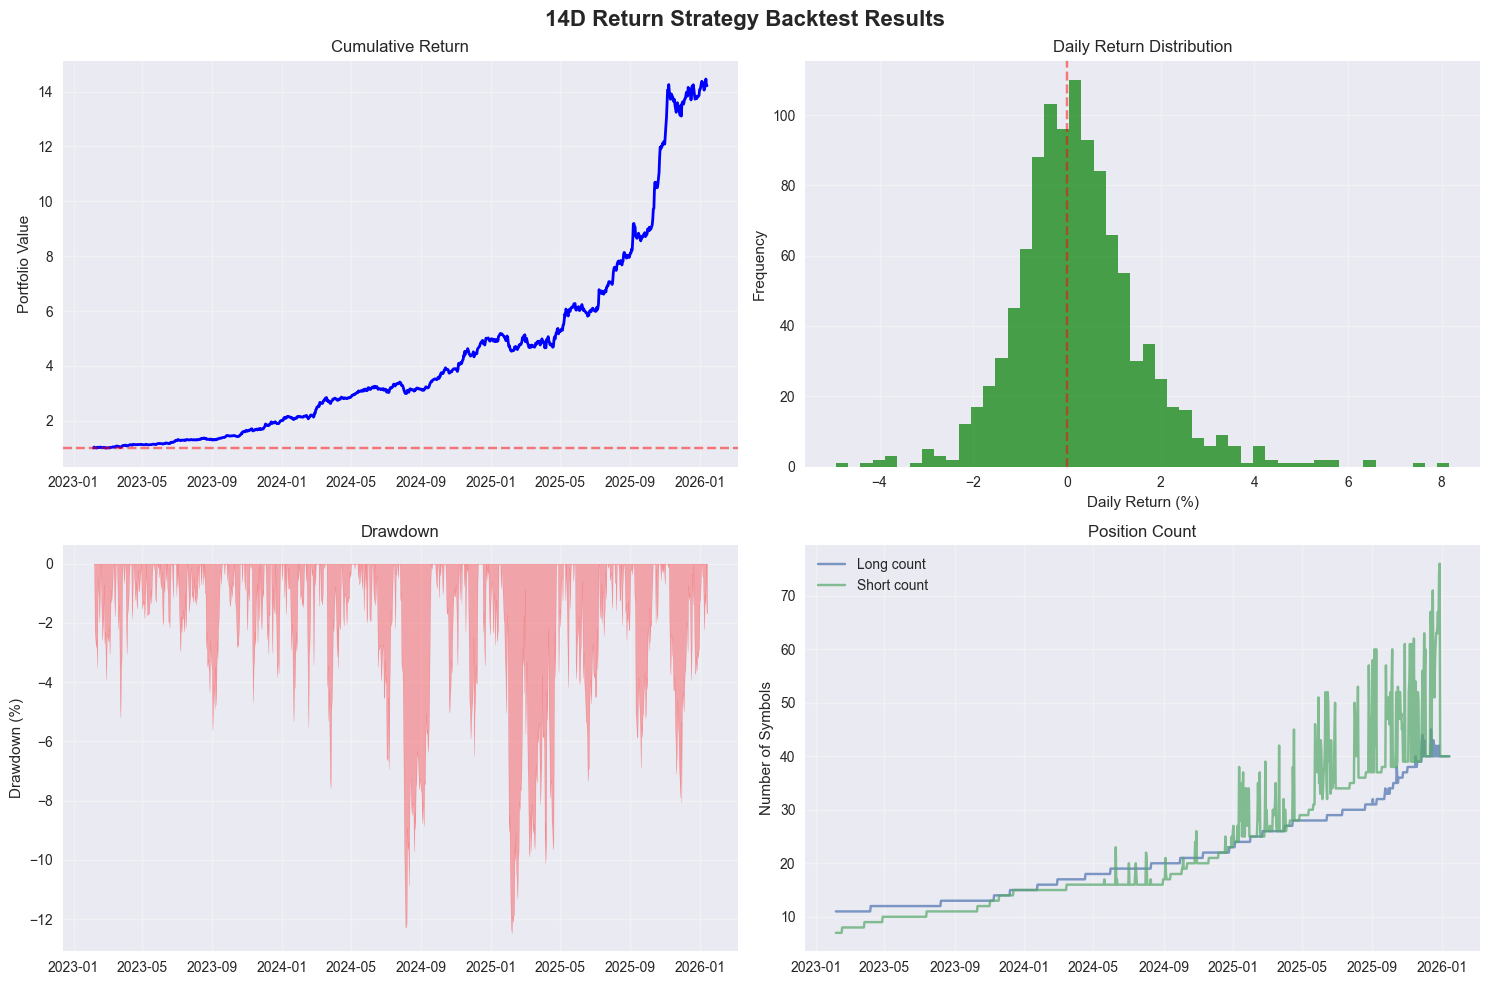

In [ ]:
# 7. パフォーマンス分析と可視化

def calculate_performance_metrics(results_df):
    """パフォーマンス指標計算"""
    
    if len(results_df) == 0:
        return None
    
    # 基本統計
    total_days = len(results_df)
    final_value = results_df['portfolio_value'].iloc[-1]
    total_return = (final_value - 1.0) * 100
    
    # 年率リターン
    years = total_days / 252
    annual_return = ((final_value) ** (1/years) - 1) * 100 if years > 0 else 0
    
    # 日次リターン統計
    daily_returns = results_df['daily_return']
    daily_mean = daily_returns.mean()
    daily_std = daily_returns.std()
    
    # シャープレシオ（年率）
    sharpe_ratio = (daily_mean * 252) / (daily_std * np.sqrt(252)) if daily_std > 0 else 0
    
    # 最大ドローダウン
    cumulative_returns = results_df['portfolio_value']
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100
    
    # 勝率
    win_rate = (daily_returns > 0).mean() * 100
    
    return {
        'total_days': total_days,
        'total_return': total_return,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'daily_vol': daily_std * 100,
        'final_value': final_value
    }

def plot_backtest_results(results_df):
    """Backtest Results Visualization"""
    
    if len(results_df) == 0:
        print("No data for plotting")
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('14D Return Strategy Backtest Results (Dynamic Daily Filter)', fontsize=16, fontweight='bold')
    
    # 1. Cumulative Return
    ax1 = axes[0, 0]
    ax1.plot(results_df['date'], results_df['portfolio_value'], linewidth=2, color='blue')
    ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Cumulative Return')
    ax1.set_ylabel('Portfolio Value')
    ax1.grid(True, alpha=0.3)
    
    # 2. Daily Return Distribution
    ax2 = axes[0, 1]
    ax2.hist(results_df['daily_return'] * 100, bins=50, alpha=0.7, color='green')
    ax2.set_title('Daily Return Distribution')
    ax2.set_xlabel('Daily Return (%)')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 3. Drawdown
    ax3 = axes[0, 2]
    cumulative = results_df['portfolio_value']
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max * 100
    ax3.fill_between(results_df['date'], drawdown, 0, color='red', alpha=0.3)
    ax3.set_title('Drawdown')
    ax3.set_ylabel('Drawdown (%)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Position Count Transition
    ax4 = axes[1, 0]
    ax4.plot(results_df['date'], results_df['long_count'], label='Long count', alpha=0.7)
    ax4.plot(results_df['date'], results_df['short_count'], label='Short count', alpha=0.7)
    ax4.set_title('Position Count')
    ax4.set_ylabel('Number of Symbols')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Eligible Symbols (日次適格銘柄数)
    ax5 = axes[1, 1]
    if 'eligible_symbols' in results_df.columns:
        ax5.plot(results_df['date'], results_df['eligible_symbols'], color='purple', alpha=0.7)
        ax5.set_title('Eligible Symbols (Daily)')
        ax5.set_ylabel('Number of Symbols')
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax5.set_title('Eligible Symbols')
    
    # 6. Rolling Sharpe Ratio (30日)
    ax6 = axes[1, 2]
    rolling_returns = results_df['daily_return'].rolling(window=30)
    rolling_sharpe = (rolling_returns.mean() * 252) / (rolling_returns.std() * np.sqrt(252))
    ax6.plot(results_df['date'], rolling_sharpe, color='orange', alpha=0.7)
    ax6.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax6.set_title('Rolling Sharpe Ratio (30d)')
    ax6.set_ylabel('Sharpe Ratio')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# パフォーマンス分析実行
if 'backtest_results' in locals() and len(backtest_results) > 0:
    performance_metrics = calculate_performance_metrics(backtest_results)
    
    print("=== バックテスト結果サマリー ===")
    print(f"期間: {backtest_results['date'].iloc[0].strftime('%Y-%m-%d')} ~ {backtest_results['date'].iloc[-1].strftime('%Y-%m-%d')}")
    print(f"取引日数: {performance_metrics['total_days']} 日")
    print(f"最終ポートフォリオ価値: {performance_metrics['final_value']:.3f}")
    print(f"総リターン: {performance_metrics['total_return']:.2f}%")
    print(f"年率リターン: {performance_metrics['annual_return']:.2f}%")
    print(f"シャープレシオ: {performance_metrics['sharpe_ratio']:.3f}")
    print(f"最大ドローダウン: {performance_metrics['max_drawdown']:.2f}%")
    print(f"勝率: {performance_metrics['win_rate']:.1f}%")
    print(f"日次ボラティリティ: {performance_metrics['daily_vol']:.2f}%")
    
    # グラフ表示
    plot_backtest_results(backtest_results)
    
else:
    print("バックテスト結果がありません。上記セルを実行してください。")


In [ ]:
# 8. 戦略詳細分析

def analyze_strategy_components(backtest_results, strategy_data):
    """戦略コンポーネント分析"""
    
    print("=== 戦略詳細分析 ===")
    
    # 基本統計
    avg_long_positions = backtest_results['long_count'].mean()
    avg_short_positions = backtest_results['short_count'].mean()
    
    print(f"平均Long銘柄数: {avg_long_positions:.1f}")
    print(f"平均Short銘柄数: {avg_short_positions:.1f}")
    
    # 日次適格銘柄数の統計
    if 'eligible_symbols' in backtest_results.columns:
        print(f"\n=== 日次適格銘柄数（14日平均出来高1M以上） ===")
        print(f"平均: {backtest_results['eligible_symbols'].mean():.1f}")
        print(f"中央値: {backtest_results['eligible_symbols'].median():.1f}")
        print(f"最小: {backtest_results['eligible_symbols'].min():.0f}")
        print(f"最大: {backtest_results['eligible_symbols'].max():.0f}")
    
    # 日次リターンの分析
    daily_returns = backtest_results['daily_return'] * 100
    
    print(f"\n=== リターン統計 ===")
    print(f"平均日次リターン: {daily_returns.mean():.3f}%")
    print(f"中央値: {daily_returns.median():.3f}%")
    print(f"標準偏差: {daily_returns.std():.3f}%")
    print(f"歪度: {daily_returns.skew():.3f}")
    print(f"尖度: {daily_returns.kurtosis():.3f}")
    
    # 最良・最悪の日
    best_day = daily_returns.max()
    worst_day = daily_returns.min()
    print(f"最良の日: {best_day:.2f}%")
    print(f"最悪の日: {worst_day:.2f}%")
    
    # 連続勝利・連続負け
    wins = daily_returns > 0
    win_streaks = []
    lose_streaks = []
    
    current_streak = 0
    is_winning = False
    
    for win in wins:
        if win:
            if is_winning:
                current_streak += 1
            else:
                if current_streak > 0:
                    lose_streaks.append(current_streak)
                current_streak = 1
                is_winning = True
        else:
            if not is_winning:
                current_streak += 1
            else:
                if current_streak > 0:
                    win_streaks.append(current_streak)
                current_streak = 1
                is_winning = False
    
    if win_streaks:
        print(f"最大連続勝利: {max(win_streaks)} 日")
    if lose_streaks:
        print(f"最大連続負け: {max(lose_streaks)} 日")

def create_benchmark_comparison():
    """ベンチマーク比較（簡易版）"""
    
    print("\n=== ベンチマーク比較参考値 ===")
    print("※ 実際のベンチマークデータは別途取得が必要")
    print(f"BTC Buy&Hold (2023年参考): +156%")
    print(f"ETH Buy&Hold (2023年参考): +92%")
    print(f"等ウェイト暗号資産ポートフォリオ (推定): +75%")
    print(f"マーケットニュートラル戦略 (一般的): +10-20%")

# 詳細分析実行
if 'backtest_results' in locals() and len(backtest_results) > 0:
    analyze_strategy_components(backtest_results, strategy_data)
    create_benchmark_comparison()
    
    print(f"\n=== 戦略評価 ===")
    perf = performance_metrics
    
    # 評価基準
    if perf['sharpe_ratio'] > 1.0:
        print("✓ シャープレシオ良好 (>1.0)")
    else:
        print("⚠ シャープレシオ要改善 (<1.0)")
        
    if perf['max_drawdown'] > -20:
        print("✓ ドローダウン許容範囲 (>-20%)")
    else:
        print("⚠ ドローダウン大きい (<-20%)")
        
    if perf['win_rate'] > 45:
        print("✓ 勝率良好 (>45%)")
    else:
        print("⚠ 勝率要改善 (<45%)")
        
    print(f"\n=== 推奨次ステップ ===")
    print("1. より長期のデータでの検証")
    print("2. 取引コスト（手数料・スプレッド）の考慮")
    print("3. リスク管理機能の追加")
    print("4. パラメータ最適化（14日→他期間テスト）")
    print("5. より多くの銘柄での検証")
    
else:
    print("バックテスト結果がありません。")


=== 戦略詳細分析 ===
平均Long銘柄数: 21.2
平均Short銘柄数: 22.3

=== リターン統計 ===
平均日次リターン: 0.257%
中央値: 0.155%
標準偏差: 1.380%
歪度: 0.830
尖度: 3.398
最良の日: 8.16%
最悪の日: -4.93%
最大連続勝利: 10 日
最大連続負け: 8 日

=== ベンチマーク比較参考値 ===
※ 実際のベンチマークデータは別途取得が必要
BTC Buy&Hold (2023年参考): +156%
ETH Buy&Hold (2023年参考): +92%
等ウェイト暗号資産ポートフォリオ (推定): +75%
マーケットニュートラル戦略 (一般的): +10-20%

=== 戦略評価 ===
✓ シャープレシオ良好 (>1.0)
✓ ドローダウン許容範囲 (>-20%)
✓ 勝率良好 (>45%)

=== 推奨次ステップ ===
1. より長期のデータでの検証
2. 取引コスト（手数料・スプレッド）の考慮
3. リスク管理機能の追加
4. パラメータ最適化（14日→他期間テスト）
5. より多くの銘柄での検証
